In [3]:
import pyemma
import numpy as np
import pyemma.coordinates as coor
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os
from matplotlib.pyplot import cm
from collections import OrderedDict
import mdtraj as md
import itertools
import time
import indices
from indices.base import BaseComparisons as bc
from indices.faith import Faith as Fai
from indices.russell_rao import RussellRao as RR
import scipy.cluster.hierarchy as shc
from matplotlib import gridspec
from matplotlib import pyplot
import mdtraj
import seaborn as sns
import collections
from sklearn.metrics.cluster import v_measure_score as v_meas
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

## Let's try it...

In [36]:
Threshold = 1
traj_prefix = '/orange/alberto.perezant/liweichang/msm/MultipleComparisons/datasets'
trajs=['complete_Gmut_steady_2.dcd','ward_Gmut_steady_1.dcd','cluster_Gmut_steady_0.dcd']
w_as=[]
for i in range(3):
    traj_file = traj_prefix+'/DESRES-Trajectory_NuG2_result/tree/cluster_1_score/'+trajs[i]
    native_pdb = traj_prefix+'/NuG2.pdb'
    feat = coor.featurizer(native_pdb)
    residues = np.arange(18,56)
    pairs = []                                                                                 
    for i,r1 in enumerate(range(18)):
        for r2 in residues[::2]:
            pairs.append([r1,r2])

    pairs = np.array(pairs)
    feature=feat.add_residue_mindist(pairs, scheme='ca',threshold=Threshold,periodic=False)
    inp = pyemma.coordinates.load(traj_file, features=feat)
    compare=bc(inp)
    w_as.append(compare.w_a)
    

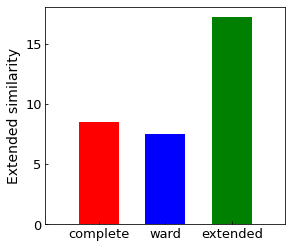

In [61]:
fig,ax=plt.subplots(1,1,figsize=(4.3,4))
plt.bar([0.5,0.75,1],height=w_as,color=['r','b','g'],width=0.15)
plt.xlim(0.3,1.2)
plt.yticks([0,5,10,15])
plt.xticks([0.5,0.75,1])
ax.set_xticklabels(['complete','ward','extended'])
ax.set_ylabel('Extended similarity',fontsize=14)
ax.tick_params(right=False, top=False, bottom=True,labelright=False, labeltop=False,axis="both", direction='in', length=3)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.savefig('/orange/alberto.perezant/liweichang/msm/MultipleComparisons/datasets/Fig_6b.pdf')


## 3GB1

In [4]:
Threshold = 0.6


traj_file = '/blue/alberto.perezant/liweichang/msm/MultipleComparisons/test_data/protein/samples_3gb1_withrandom_shuffled.dcd'
native_pdb = '/blue/alberto.perezant/liweichang/msm/MultipleComparisons/test_data/protein/3GB1.pdb'
traj = md.load_dcd(traj_file,top=native_pdb)
feat = coor.featurizer(native_pdb)
residues = np.arange(0,56)
pairs = []                                                                                 
for i,r1 in enumerate(range(56)):
    for r2 in residues[r1:]:
        pairs.append([r1,r2])

pairs = np.array(pairs)
feature=feat.add_residue_mindist(pairs, scheme='closest-heavy',threshold=Threshold,periodic=False)
inp = pyemma.coordinates.load(traj_file, features=feat)
# compare=bc(inp)
# w_as.append(compare.w_a)
np.savez('proteinG_shuffled_fingerprint.npz',inp.astype(np.int32))

In [11]:
# for i in range(30):
#     sample_index=np.random.choice(traj.n_frames,1200,replace=False)
#     traj[sample_index].save_dcd('test_data/protein/test_linkages/subsample_3gb1_{}.dcd'.format(i))
#     label=[int(i) for i in np.loadtxt('test_data/protein/samples_3gb1_shuffled_label.dat')]
#     np.savetxt('test_data/protein/test_linkages/subsample_3gb1_label_{}.dat'.format(i),np.array(label)[sample_index])

(1923,)

In [27]:
# %%timeit -n1 -r1 
all_start = time.time()
all_input = list(itertools.combinations(inp, 2))
batch_size=1000000
inp_sliced=[all_input[i*batch_size:(i+1)*batch_size] for i in range(int(len(all_input)/batch_size))]
if int(len(inp_sliced)) < len(all_input)/batch_size:
    inp_sliced.append(all_input[len(inp_sliced)*batch_size:])
for i in range(len(inp_sliced)):
    temp_start = time.time()
    temp_c = np.zeros((int(len(inp_sliced[i])),3))
    temp_input = np.array(inp_sliced[i])
    product = temp_input.reshape(-1,2,temp_input.shape[-1]).sum(1)
    for row in range(3):
        temp_c[:,row] = np.sum(product==row,axis=1)
    if i == 0:
        all_c = temp_c
    else:
        all_c = np.concatenate((all_c,temp_c),axis=0)
    print('all_c shape =', all_c.shape)
    temp_end = time.time()
    temp_time = temp_end - temp_start
    print('step {} time ='.format(i),round(temp_time,2),'s')


###calculate similarity
#simi = all_c[:,0]+all_c[:,2]
simi = all_c[:,2]
###try Faith
Faith=False
if Faith:
    faith_simi = 0.5*all_c[:,0]+all_c[:,2]
    denominate = all_c[:,0]+all_c[:,1]+all_c[:,2]
    w_p = faith_simi/denominate
    simi_matrix = np.zeros((len(inp),len(inp)))
    indices = np.triu_indices(len(inp),k=1)
    indices = (indices[1],indices[0])
    simi_matrix[indices] = w_p
else:
    simi_matrix = np.zeros((len(inp),len(inp)))
    indices = np.triu_indices(len(inp),k=1)
    indices = (indices[1],indices[0])
    simi_matrix[indices] = simi
print('final matrix shape = ', simi_matrix.shape)
all_end = time.time()
all_time = all_end - all_start
print('total time =', round(all_time,2),'s')

all_c shape = (1000000, 3)
step 0 time = 24.24 s
all_c shape = (1403650, 3)
step 1 time = 11.53 s
final matrix shape =  (1676, 1676)
total time = 36.11 s


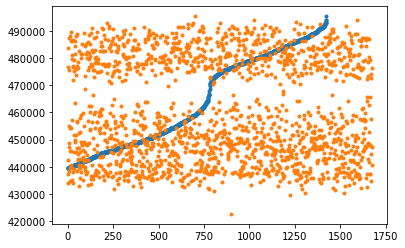

In [28]:
#np.unravel_index(np.argmax(simi, axis=None),simi.shape)
fliped_simi_matrix = np.fliplr(simi_matrix)
mirror_binary_simi=simi_matrix+np.rot90(fliped_simi_matrix)
sum_mirror_binary_simi = np.sum(mirror_binary_simi.T,axis=1)
sum_mirror_binary_simi_index = np.vstack((sum_mirror_binary_simi,range(len(sum_mirror_binary_simi)))).T
outlier_ratio = 0.15
plt.scatter(range(sum_mirror_binary_simi.shape[0]-int(sum_mirror_binary_simi.shape[0]*outlier_ratio)),sorted(sum_mirror_binary_simi)[int(sum_mirror_binary_simi.shape[0]*outlier_ratio):],marker='.')
plt.scatter(range(sum_mirror_binary_simi.shape[0]),sum_mirror_binary_simi,marker='.')
# plt.scatter(sample_index,sum_mirror_binary_simi[sample_index],marker='.')
sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()][::-1]
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
index_aa=[]
# for index_a,i in enumerate(sum_mirror_binary_simi_index[:,0]):
#     if 360000 <i :
#         index_aa.append(int(sum_mirror_binary_simi_index[:,1][index_a]))
for index_a,i in enumerate(sum_mirror_binary_simi):
    if 1140000 <i and index_a>1446:
        index_aa.append(index_a)
# plt.scatter(a,sum_mirror_binary_simi[a],marker='.')
        

In [9]:
sorted_sum_mirror_binary_simi_index = sum_mirror_binary_simi_index[sum_mirror_binary_simi_index[:,0].argsort()]
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index.astype('int')
sorted_sum_mirror_binary_simi_index = sorted_sum_mirror_binary_simi_index[int(sum_mirror_binary_simi.shape[0]*outlier_ratio):]
sample_index=sorted_sum_mirror_binary_simi_index[:,1].tolist()
# simi_matrix = simi_matrix[:,sample_index][sample_index]
# simi_matrix
# inp.shape[0]
len(sample_index)

400

In [29]:
import pandas  as pd
all_start=time.time()
inp_copy=inp#[sample_index]
df = pd.DataFrame(simi_matrix,columns=pd.MultiIndex.from_tuples([('{}'.format(i),'{}'.format(i)) for i in range(1,len(inp_copy)+1)],names=['cluster', 'frame']))
dic={}
hie_tree=[]
dentrom=[]
time_step=[]
while df.shape[0] > 2:
    ###update df
    frame_column=[i[1] for i in df.columns.to_list()]
    hie_tree.append(frame_column)
    new_max=np.argmax(df, axis=None)     ###2.5s

    del_index = np.unravel_index(new_max, df.shape)
    max_value = df.to_numpy()[del_index[0]][del_index[1]] ###0.1s

    ###get temp inp
    delete_row=[int(i) for i in df.columns[del_index[0]][1].split(',') ]
    delete_cluster_row=[int(i) for i in df.columns[del_index[0]][0].split(',')]
    delete_column=[int(i) for i in df.columns[del_index[1]][1].split(',') ]
    delete_cluster_column=[int(i) for i in df.columns[del_index[1]][0].split(',')]
    dentrom.append([*delete_cluster_column,*delete_cluster_row])

    delete_all=delete_column+delete_row
    insert_index='{}'.format(delete_all)[1:-1]   ###0.1s
    insert_cluster_index='{}'.format(2*len(inp) - df.shape[0]+1)
    df.drop(columns=[('{}'.format(delete_cluster_column)[1:-1],'{}'.format(delete_column)[1:-1]),('{}'.format(delete_cluster_row)[1:-1],'{}'.format(delete_row)[1:-1])],axis=1,inplace=True)
    df.drop(index=[*del_index],axis=0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    temp_w_sim=[]            ###1s

    ###get temp inp
   # print(df.columns)
    frame_column=[i[1] for i in df.columns.to_list() ]
    columns=[[int(d) for d in [*i.split(',')]] for i in frame_column]
    temp_inp=[[inp_copy[d-1] for d in m] for m in columns]    ###0.1s

    ###perform comparison
#     if Faith:
#         for i in temp_inp:
#             compare=Fai(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
#             temp_w_sim.append(compare.Fai_1sim_wdis)
#     else:
    for i in temp_inp:
       # compare=bc(np.concatenate(([inp_copy[d-1] for d in delete_all],i),axis=0))
        compare=bc(np.concatenate((inp_copy[np.array(delete_all)-1],i),axis=0))
        temp_w_sim.append(compare.w_a)         ###1s
#     temp_start = time.time()
  #  inp_copy = temp_inp
    temp_w_sim=[0]+temp_w_sim
    df.loc[-1] = [0]*df.shape[1] # adding a row
    df.index = df.index + 1  # shifting index
    df = df.sort_index()  # sorting by index
   # print(df.shape)
    if df.shape[0] % 100 == 0:
        all_end = time.time()
        all_time = all_end - all_start
        print('merge {} clusters time ='.format(df.shape[0]), round(all_time,2),'s')
        time_step.append(round(all_time,4))
    df.insert(loc=0, column=(insert_cluster_index,insert_index), value=temp_w_sim)

    dic[insert_index]=max_value
temp_end = time.time() 
temp_time = temp_end - all_start          
print('merge {} clusters time ='.format(df.shape[0]), round(temp_time,2),'s')
time_step.append(round(temp_time,4))
last_two = [int(i[0]) for i in df.columns.to_list()]
dentrogram = np.vstack(dentrom)-np.ones((1,2))
values = np.max(simi_matrix)-np.array([*dic.values()],ndmin=2)+2
num_frames = np.array([len(i) for i in [[int(d) for d in [*k.split(',')]] for k in list(dic.keys())]],ndmin=2)
tree = np.hstack((dentrogram,values.T,num_frames.T))
tree = np.vstack((tree, [[last_two[0]-1,last_two[1]-1,np.max(simi_matrix)-df.to_numpy()[1][0],len(inp)]]))

merge 1600 clusters time = 24.9 s
merge 1500 clusters time = 59.39 s
merge 1400 clusters time = 94.55 s
merge 1300 clusters time = 127.15 s
merge 1200 clusters time = 158.95 s
merge 1100 clusters time = 187.58 s
merge 1000 clusters time = 214.59 s
merge 900 clusters time = 241.32 s
merge 800 clusters time = 271.06 s
merge 700 clusters time = 295.03 s
merge 600 clusters time = 319.42 s
merge 500 clusters time = 340.49 s
merge 400 clusters time = 359.28 s
merge 300 clusters time = 375.95 s
merge 200 clusters time = 389.83 s
merge 100 clusters time = 401.88 s
merge 2 clusters time = 410.44 s


In [11]:
def plot_simi_threshold(tree,p,min_simi=True,save=False):
    plt.figure(figsize=(20, 8))
    dend = shc.dendrogram(tree,p=p,truncate_mode='lastp')
    if min_simi:
        plt.axhline(y=min_simi, color='r', linestyle='-')
    plt.xlabel('Num_samples')
    plt.ylabel('Simi_value')
    if save:
        plt.savefig('simi_threshold_tree.png')

def get_step_index(hie_tree,cluster_step):
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    label_index = sorted(label_index, key=lambda x:len(x), reverse=True)
    return label_index
def plot_test_result(true_rmsd,hie_tree,cluster_step,setylim,save=False):
    colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
             'black','brown','navy','indigo','cyan','teal','violet','royalblue']
    fig, ax = plt.subplots(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[15, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    label_index = [[int(i)-1 for i in hie_tree[cluster_step][d].split(',')] for d in range(len(hie_tree[cluster_step]))]
    label_index = sorted(label_index, key=lambda x:len(x), reverse=True)
    if len(label_index) > 10:
        label_index = label_index[:10]
    test_rmsd = [[true_rmsd[i] for i in label_index[d]] for d in range(len(label_index))]
    for index,i in enumerate(test_rmsd):
        ax0.scatter(label_index[index],i,marker='.',color=colors[index])
    percentage=[len(i)/len(true_rmsd) for i in test_rmsd]
    sum_percentage = [0.0]+[sum(percentage[:i]) for i in range(1,len(percentage))]+[1.0]
    ax0.set_xlabel('Sample')
    ax0.set_ylabel('RMSD')
    cmap = mpl.colors.ListedColormap(colors[:len(test_rmsd)])
    print(colors[:len(test_rmsd)])
    norm = mpl.colors.BoundaryNorm(sum_percentage, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=sum_percentage,
                                    ticks=sum_percentage+[1.0],
                                    spacing='proportional')
    cb2.set_label('Cluster samples ratio')
    if setylim:
        ax0.set_ylim(setylim[0],setylim[1])
    if save:
        plt.savefig('simi_threshold_tree.png')
    return label_index

In [15]:
traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
traj=traj[::10]#0][sample_index]
true_rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
#label_index = plot_test_result(true_rmsd,hie_tree,-4,setylim=[0,1])
# plt.scatter(range(len(index_aa)),true_rmsd[index_aa])

In [207]:
import copy 
rest_index = [i for i in range(len(inp)) if i not in list(np.array(range(9998))[::20])]
origi_index = list(np.array(range(len(inp)))[::20])
rest_label_index = copy.deepcopy(label_index)

In [32]:
# all_label_index_bc = [bc(inp_copy[label_index[i]]).total_w_sim for i in range(len(label_index))]
# all_label_index_bc
#[len(rest_label_index[i]) for i in range(len(label_index))]
list(np.array([1,2,34,6,7,4,7,8])[[2,3]])

[34, 6]

In [17]:
# colors = ['grey', 'purple', 'blue', 'green', 'orange', 'red',
#              'black','brown','navy','indigo','cyan','teal','violet','royalblue']
# traj = md.load_dcd('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd',top='../proteinG_3gb1/3GB1.pdb')
# for i in range(len(label_index)):
#     true_rmsd=md.rmsd(traj[rest_label_index[i]],pdb,atom_indices=all_CA)
#     plt.scatter(rest_label_index[i],true_rmsd,color=colors[i],marker='.')
# plt.ylim(0,1)

In [69]:
# all_start=time.time()
# inp = pyemma.coordinates.load('../proteinG_3gb1/yhalfres_0_0/trajectory.00.dcd', features=feat)
# rest_inp = inp[rest_index]
# for rest_inp_index, d in enumerate(rest_inp):
#     change_index = []
#     for i in range(len(label_index)):
#        # before = bc(inp_copy[label_index[i]]).total_w_sim
#         after = bc(np.concatenate((inp_copy[label_index[i]],[d]),axis=0)).total_w_sim
#         change = (all_label_index_bc[i] - after)/all_label_index_bc[i]
#         change_index.append(change)
#         belong_index = np.argmin(change_index)
#     if rest_inp_index % 100 == 0:
#         print(rest_inp_index, ' finished')
#     rest_label_index[belong_index].append(rest_index[rest_inp_index])
# temp_end = time.time() 
# temp_time = temp_end - all_start  
# print('time =', round(temp_time,2),'s')

In [7]:
# label_concate = np.concatenate(label_index)
traj = md.load_dcd(traj_file,top='../proteinG_3gb1/3GB1.pdb')
topfile=traj.top
pdb=md.load_pdb('../proteinG_3gb1/3GB1.pdb')
all_CA=topfile.select("backbone==1")
# rmsd=md.rmsd(traj,pdb,atom_indices=all_CA)
# traj_cluster=traj[label_concate]
# cluster_rmsd=md.rmsd(traj_cluster,pdb,atom_indices=all_CA)
# for index,i in enumerate(label_index):
#     traj_cluster=traj[i]
#     cluster_rmsd=md.rmsd(traj_cluster,pdb,atom_indices=all_CA)
#     plt.scatter(i,list(cluster_rmsd),marker='.',label=index)
# traj_cluster=traj[label_concate]
# plt.ylim(0,2)
# plt.legend()

In [62]:
# b=[i for i in range(rmsd.shape[0]) if i not in a]
traj_cluster=md.load_dcd('test_data/protein/samples_3gb1_withrandom_shuffled.dcd',top=native_pdb)
(traj_cluster[labels==0][3]+traj_cluster[labels==1][0]+traj_cluster[labels==2][0]+traj_cluster[labels==3][0]\
+traj_cluster[labels==4][0]+traj_cluster[labels==5][0]).save_pdb('test_data/protein/seeds_3gb1.pdb')

/home/liweichang/anaconda3/envs/msm/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
(1849926,)


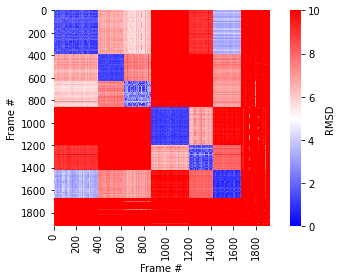

In [11]:
traj_cluster=md.load_dcd('test_data/protein/samples_3gb1_withrandom_shuffled.dcd',top=native_pdb)
labels=np.loadtxt('test_data/protein/samples_3gb1_label_withrandom_shuffled.dat')
traj_cluster=traj_cluster[labels==0]+traj_cluster[labels==1]+traj_cluster[labels==2]+traj_cluster[labels==3]+traj_cluster[labels==4]\
            +traj_cluster[labels==5]+traj_cluster[labels==-1]
rmsd_2d=np.zeros((len(traj_cluster),len(traj_cluster)))
upper_indices = np.triu_indices(len(traj_cluster),k=0)
lower_indices = (upper_indices[1],upper_indices[0])
r2d = []
for i in range(len(traj_cluster)):
    r2d.append(md.rmsd(traj_cluster[i:],traj_cluster[i],atom_indices=all_CA))
    if i % 100 == 0:
        print(i)
print(np.concatenate(r2d).shape)
rmsd_2d[lower_indices] = np.concatenate(r2d)
rmsd_2d[upper_indices] = np.concatenate(r2d)
sns.heatmap(rmsd_2d*10,square=True,xticklabels=200,yticklabels=200,cmap='bwr',cbar_kws={'label':'RMSD'},vmin=0,vmax=10)
plt.xlabel("Frame #")
plt.ylabel("Frame #")
ax = plt.gca()
ax.tick_params(direction='out')
plt.tight_layout()
plt.savefig('/orange/alberto.perezant/liweichang/msm/MultipleComparisons/datasets/Fig_S2b.pdf')


[385, 345, 297, 224, 218, 207]

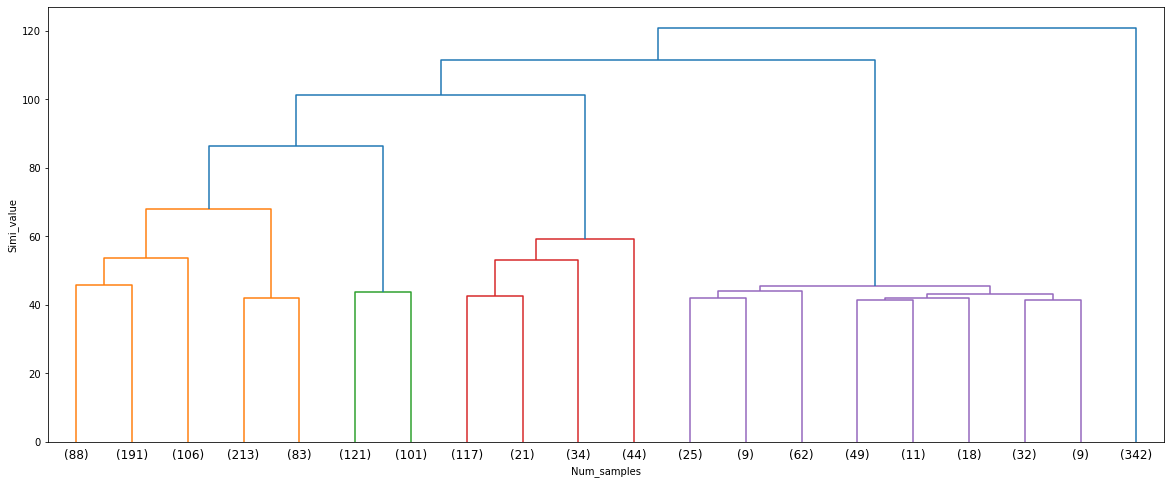

In [30]:
plot_simi_threshold(tree,20,min_simi=False)
# [len(i) for i in label_index]
# list(dic.items())[-20:]
[385, 345, 297, 224, 218, 207]

In [31]:
label=[int(i) for i in np.loadtxt('test_data/protein/samples_3gb1_shuffled_label.dat')]
cluster_label=np.zeros((len(traj)))
for i in range(len(label_index)):
    cluster_label[label_index[i]]=i
cluster_label=np.array([i for i in np.array(cluster_label) if i != -1])
# v_meas(np.array([i for i in np.array(label) if i != -1]),cluster_label[np.array(label)!=-1])
print(sorted([(np.array(label)==i).sum() for i in range(6)]))
print(sorted([385, 345, 297, 224, 218, 207]))

[219, 233, 238, 251, 339, 396]
[207, 218, 224, 297, 345, 385]


In [320]:
# list(dic.items())[-2][0]
# len([int(s) for s in list(dic.items())[-2][0].split(',')])
# checks=[int(i-inp_len) for i in np.concatenate(tree[np.array(step)[np.array(diff)>5]][:,:2]) if i > inp_len]
# print(checks[25:])
# checks=np.array(list(dic.items()))[:,0][checks[25:]]
# checkss=np.unique(np.concatenate([[int(s) for s in d.split(',')] for d in checks]))
tree[np.array(step)[np.array(diff)>20]]

array([[2845.        , 2844.        ,  107.30237154, 1012.        ],
       [2842.        , 2835.        ,   95.10895884,  413.        ],
       [2843.        , 2841.        ,   81.52773376,  631.        ]])

In [442]:
tree#[3371-inp_len]

array([[3.96000000e+02, 4.23000000e+02, 2.00000000e+00, 2.00000000e+00],
       [3.98000000e+02, 4.25000000e+02, 2.00000000e+00, 2.00000000e+00],
       [3.99000000e+02, 4.26000000e+02, 2.00000000e+00, 2.00000000e+00],
       ...,
       [3.36700000e+03, 3.36500000e+03, 1.52374723e+02, 4.51000000e+02],
       [3.36900000e+03, 3.36200000e+03, 1.68263754e+02, 1.23600000e+03],
       [3.37100000e+03, 3.37000000e+03, 1.87494961e+02, 1.68700000e+03]])

In [31]:
diff=[]
single_merge=[]
single_merge_step=[]
step=[]
inp_len=inp.shape[0]
for i in list(range(tree.shape[0]))[1:][::-1]:
    a=tree[i][0]
    b=tree[i][1]
    if a > inp_len:
        a=tree[i][0]-inp_len
        if b > inp_len:
            b=tree[i][1]-inp_len
            temp_diff = tree[i][2] - max(tree[int(a)][2],tree[int(b)][2])
            diff.append(temp_diff)
            step.append(i)
        else:
            temp_diff = tree[i][2] - tree[int(a)][2]
            diff.append(temp_diff)
            step.append(i)
            single_merge.append(temp_diff)
            single_merge_step.append(b)
    else:
        if b > inp_len:
            b=tree[i][1]-inp_len
            temp_diff = tree[i][2] - tree[int(b)][2]
            diff.append(temp_diff)
            step.append(i)
            single_merge.append(temp_diff)
            single_merge_step.append(a)
len(diff)

1182

In [33]:
np.array(step)[np.array(diff)>10]
# np.array(list(dic.items()))[-1][1]
# len([[int(s) for s in d.split(',')] for d in np.array(list(dic.items()))[:,0]][-2])
# tree[-2]
np.save('3gb1_clustering_tree.npy',tree)

In [48]:
checks=np.array(list(dic.items()))[:,0][np.array(step)[np.array(diff)>7][5:]]
checkss=np.unique(np.concatenate([[int(s) for s in d.split(',')] for d in checks]))
tree[np.array(step)[np.array(diff)>7]]
# tree[np.array(step[:100])[np.array(diff[:100])>15]][:,3]


array([[3.34800000e+03, 3.34100000e+03, 9.51510143e+01, 1.33100000e+03],
       [3.34700000e+03, 3.34500000e+03, 8.61583630e+01, 1.12400000e+03],
       [3.34600000e+03, 3.34000000e+03, 7.46710817e+01, 9.06000000e+02],
       [3.34400000e+03, 3.32300000e+03, 6.23519062e+01, 6.82000000e+02],
       [3.33200000e+03, 3.23800000e+03, 4.89595376e+01, 1.73000000e+02],
       [2.95100000e+03, 1.28300000e+03, 3.78235294e+01, 1.70000000e+01],
       [2.44500000e+03, 1.60400000e+03, 3.50000000e+01, 3.00000000e+00],
       [2.14000000e+03, 9.62000000e+02, 3.10000000e+01, 3.00000000e+00],
       [2.16200000e+03, 4.80000000e+02, 2.90000000e+01, 3.00000000e+00],
       [2.09300000e+03, 1.52300000e+03, 2.70000000e+01, 3.00000000e+00],
       [1.83200000e+03, 2.37000000e+02, 2.50000000e+01, 3.00000000e+00],
       [1.74400000e+03, 1.75000000e+02, 2.50000000e+01, 3.00000000e+00],
       [1.97600000e+03, 1.00000000e+00, 2.50000000e+01, 3.00000000e+00],
       [1.70700000e+03, 1.36100000e+03, 1.70000000e

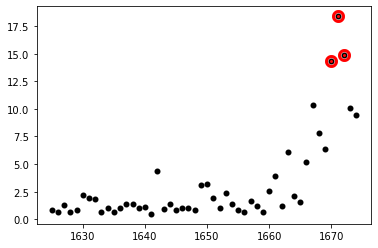

In [32]:
# diff=[tree[:,2][i]-tree[:,2][i-1] for i in range(1,tree[:,2].shape[0]-1)]
plt.scatter(step[:50],diff[:50],marker='.',linewidths=3,color='black')
plt.scatter(step[2:5],diff[2:5],marker='.',linewidths=10,color='r')
# plt.scatter(single_merge_step,single_merge,marker='.')
# np.array(step)[np.array(diff)>5]
# [[int(s) for s in d.split(',')] for d in checks]